# Autoencoder Example Notebook

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import pickle
import shutil

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from keras.models import load_model
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.utils import resample
from scipy.cluster.vq import kmeans2, whiten
from sklearn.decomposition import PCA


# Mount the drive and clone the github repo
drive.mount('/content/drive/')
!git clone https://github.com/afarley9/perovskites.git

# Import modules from the github repo
sys.path.append("/content/perovskites/perovskites")
import utils.image_processing as impr
import utils.image_loader as loader
import utils.miscellaneous as misc
from utils.autoencoder_to_encoder import autoencoder

MODEL_LOG_FOLDER = "drive/Shareddrives/Perovskites_DIRECT/models"
MODEL_INFO = loader.MODEL_INFO
final_img_size = MODEL_INFO['target_image_size_pix']

Mounted at /content/drive/
Cloning into 'perovskites'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 1149 (delta 257), reused 212 (delta 116), pack-reused 782
Receiving objects: 100% (1149/1149), 23.00 MiB | 25.82 MiB/s, done.
Resolving deltas: 100% (709/709), done.


To run on TPU go to `Runtime > Change Runtime Type > TPU`

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.43.169.242:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.43.169.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.43.169.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Load Dataset**

In [3]:
dataset = loader.PLDataLoader()

**Create instance of autoencoder with the autoencoder class**

In [4]:
file_name = 'Autoencoder_example.h5'
ae = autoencoder(h5_name=file_name)

**Extract Autoencoder/Encoder**

This uses autoencoder class train and extract autoencoder/encoder with the .`extract_autoencoder()` method

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

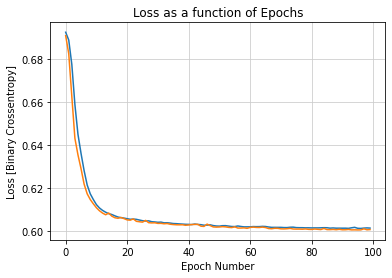

In [5]:
decoded, encoded = ae.extract_autoencoder(optimizer='adam', epochs=100)

**Normalize the data**

In [6]:
X_train = dataset.X / dataset.X.max() #Normalize data

**Visualize the autoencoder**


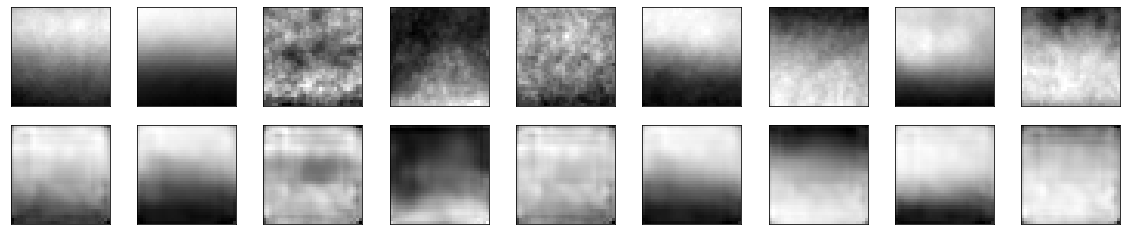

In [7]:
autoencoded_imgs = decoded.predict(X_train)

n = 9 
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_train[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(autoencoded_imgs[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show() 

**We can also load weights from previous model if we don't want to train another one**

In [8]:
decoder_shell, encoder_shell = ae.build_autoencoder()
decoder_shell.load_weights('/content/drive/Shareddrives/Perovskites_DIRECT/models/autoencoder_model/jasonlikespickles.h5')

encoder_path = '/content/drive/Shareddrives/Perovskites_DIRECT/models/encoder_model/jasonlikespickles.h5'
encoder_shell.load_weights(encoder_path)

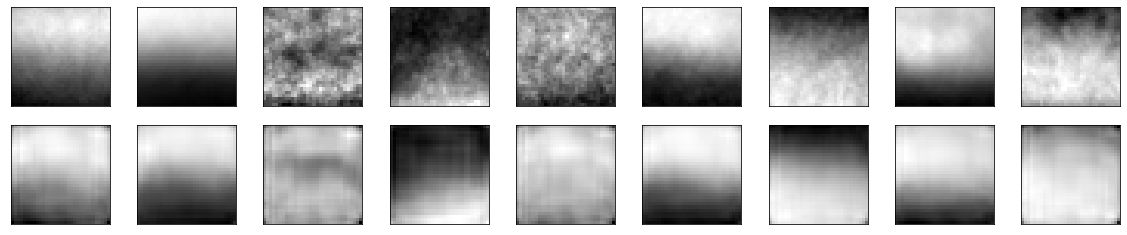

In [9]:
autoencoded_imgs = decoder_shell.predict(X_train)

n = 9 
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_train[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(autoencoded_imgs[i].reshape(32,32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

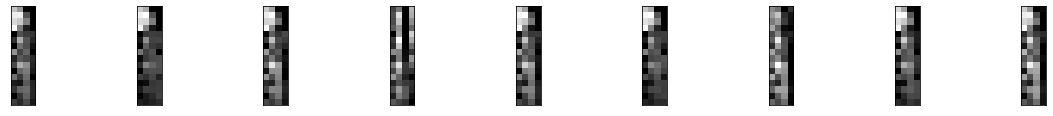

In [10]:
encoded_imgs = encoder_shell.predict(X_train)
n = 9 
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(encoded_imgs[i].reshape(4*4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**This class can also be used to retrieve the classification output to run through a linear regression**

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 8)           0   

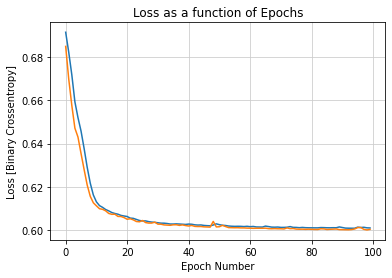

In [15]:
lin_reg_return = ae.autoencoder_to_classification()